# Quantify the difference in Complexity Penalty between Unconstrained and OAK

In [2]:
%run imports.py

All packages loaded successfully.


In [3]:
# --- Sample from a GP ---
lengthscale = 0.2
variance = 1
noise = 0.1

np.random.seed(0)
tf.random.set_seed(0)

kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)
mean_function = gpflow.mean_functions.Constant(c=3.0)

X_grid = np.linspace(-4,4,1000).reshape(-1,1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)


mean = mean_function(X_grid_tf)
cov = kernel.K(X_grid_tf)

L = tf.linalg.cholesky(cov + tf.eye(tf.shape(cov)[0], dtype=tf.float64) * 1e-6)
z = tf.random.normal([tf.shape(X_grid_tf)[0], 1], dtype=tf.float64)
f_samples = (mean + tf.matmul(L, z)).numpy().squeeze()

X_data = np.random.normal(loc=0.0, scale=1.0, size=(500,1))
f_interp = interp1d(X_grid.flatten(), f_samples, fill_value="extrapolate")
Y_data = f_interp(X_data.flatten()).reshape(-1,1) + np.random.normal(0, noise, size=len(X_data)).reshape(-1,1)


kf = KFold(n_splits=5, shuffle=True, random_state=0)
X_train, X_test, Y_train, Y_test = None, None, None, None
for train_index, test_index in kf.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    break

In [4]:
# --- Create OAK model ---
data = (X_train, Y_train)
oak = create_model_oak(
    data=data,
    max_interaction_depth=1,
    constrain_orthogonal=False,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)

oak.kernel.variances[0].assign(9)
gpflow.set_trainable(oak.kernel.variances[0], False)
oak.kernel.variances[1].assign(1)
gpflow.set_trainable(oak.kernel.variances[1], False)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(oak)
print(f"Training NLL is {oak.training_loss()}")

K_oak = oak.kernel.K(X_train, X_train) + tf.eye(len(Y_train), dtype=tf.float64) * oak.likelihood.variance.numpy()
alpha_oak = tf.linalg.solve(K_oak, tf.convert_to_tensor(Y_train, dtype=tf.float64))
oak_datafit = 0.5 * Y_train.T@alpha_oak
L = tf.linalg.cholesky(K_oak)
oak_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L))).numpy()

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.213614   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 9          │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[1]            │ Parameter │ Softplus         │         │ False       │ ()      │ float64

In [5]:
# --- Create OAK model ---
data = (X_train, Y_train)
model = create_model_oak(
    data=data,
    max_interaction_depth=1,
    constrain_orthogonal=False,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)

model.kernel.variances[0].assign(0.00001)
gpflow.set_trainable(model.kernel.variances[0], False)
model.kernel.variances[1].assign(10)
gpflow.set_trainable(model.kernel.variances[1], False)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(model)
print(f"Training NLL is {model.training_loss()}")

K_model = model.kernel.K(X_train, X_train) + tf.eye(len(Y_train), dtype=tf.float64) * model.likelihood.variance.numpy()
alpha_model = tf.linalg.solve(K_model, tf.convert_to_tensor(Y_train, dtype=tf.float64))
model_datafit = 0.5 * Y_train.T@alpha_model
L_model = tf.linalg.cholesky(K_model)
model_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_model))).numpy()

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.265641   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │  1e-05      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.variances[1]            │ Parameter │ Softplus         │         │ False       │ ()      │ 

In [6]:
# --- Verify the Posteriors and Data Fit Terms are identical ---
x_plot = np.linspace(-2, 2, 150).reshape(-1,1)

y_model, _ = model.predict_f(x_plot)
y_oak, _ = oak.predict_f(x_plot)

print(f"MSE is {mean_squared_error(y_model, y_oak)}")

MSE is 3.122609105145926e-05


In [7]:
print(oak_datafit.numpy()[0][0], model_datafit.numpy()[0][0])
print()
print(oak_complexity, model_complexity)

200.6746555708765 196.22794397316235

-834.3160698462299 -816.825453233343


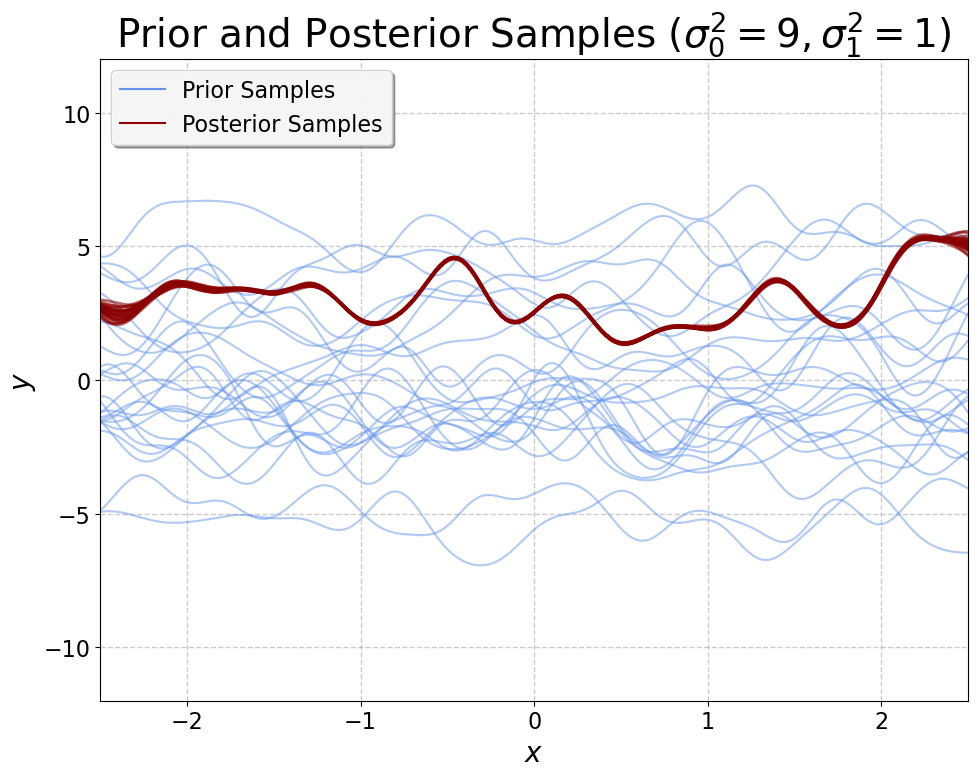

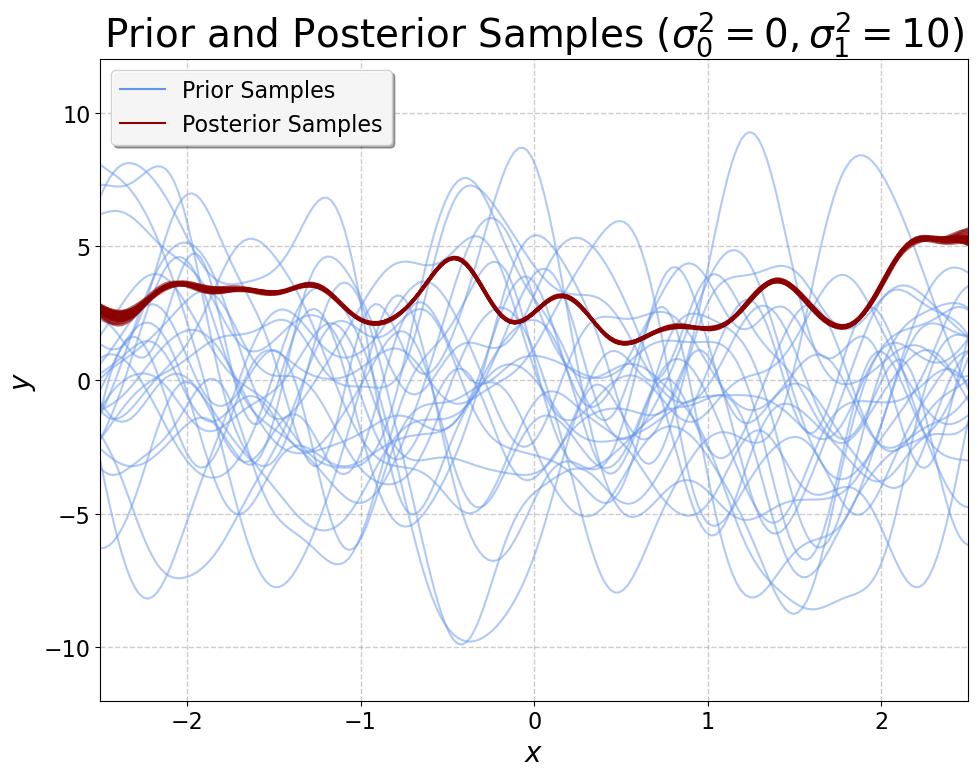

In [8]:
# --- Visualise the difference in function draws from the priors ---
num_samples = 25
num_test_points = 200
plot_range = (-2.5, 2.5)

# --- Test Data for 1D Models ---
X_test = np.linspace(plot_range[0], plot_range[1], num_test_points).reshape(-1, 1)


def plot_model_samples(ax, model_to_plot, X_test_data, title):
    """
    Plots prior and posterior samples for a 1D Gaussian Process model.
    """
    num_points = X_test_data.shape[0]
    
    # --- Prior Samples ---
    kernel = model_to_plot.kernel
    K = kernel(X_test_data)
    jitter = 1e-6
    K += jitter * np.eye(num_points)
    mean_vector = np.zeros(num_points)
    prior_samples = np.random.multivariate_normal(mean_vector, K, size=num_samples)

    # --- Posterior Samples ---
    posterior_samples = model_to_plot.predict_f_samples(X_test_data, num_samples)[:, :, 0]

    # --- Plotting ---
    x_plot = X_test_data.flatten()

    # Plot each prior and posterior sample
    for i in range(num_samples):
        ax.plot(x_plot, prior_samples[i, :], '-', color='cornflowerblue', lw=1.5, alpha=0.5)
    for i in range(num_samples):
        ax.plot(x_plot, posterior_samples[i, :], '-', color='darkred', lw=2, alpha=0.6)

    # Create dummy plots for a clean legend
    ax.plot([], [], '-', color='cornflowerblue', label='Prior Samples')
    ax.plot([], [], '-', color='darkred', label='Posterior Samples')
    
    ax.set_title(title, fontsize=28)
    ax.legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=16)
    ax.set_xlim(plot_range)
    ax.set_ylim([-12,12])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(True, linestyle='--', alpha=0.4)

# --- Figure 1: OAK Model ---
fig_oak, ax_oak = plt.subplots(figsize=(10, 8))
plot_model_samples(ax_oak, oak, X_test, 'Prior and Posterior Samples ($\\sigma_0^2=9, \\sigma_1^2=1$)')
plt.tight_layout()
plt.show()


# --- Figure 2: Standard GP Model ---
fig_model, ax_model = plt.subplots(figsize=(10, 8))
plot_model_samples(ax_model, model, X_test, 'Prior and Posterior Samples ($\\sigma_0^2=0, \\sigma_1^2=10$)')
plt.tight_layout()
plt.show()